In [1]:
%load_ext autoreload
%autoreload 2

# IQA tracking params and variables

> When using parametric layers we have to be able to keep track of the parameters and the variables of the model (which are not going to be trained). We're going to play with this concept using our implementation of the functional layers.

In [2]:
# import os; os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".99"

In [3]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from typing import Any, Callable, Sequence, Union
import numpy as np

import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

import jax
from jax import lax, random, numpy as jnp
import flax
from flax.core import freeze, unfreeze, FrozenDict
from flax import linen as nn
from flax import struct
from flax.training import train_state
from flax.training import orbax_utils

import optax
import orbax.checkpoint

from clu import metrics
from ml_collections import ConfigDict

from einops import reduce, rearrange
import wandb
from iqadatasets.datasets import *
from fxlayers.layers import *
from fxlayers.layers import GaussianLayerGamma, GaborLayerLogSigma_, GaborLayerLogSigmaCoupled_
from fxlayers.initializers import *
from JaxPlayground.utils.constraints import *
from JaxPlayground.utils.wandb import *

2023-11-10 16:27:42.000726: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-10 16:27:42.029661: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-10 16:27:42.030154: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-10 16:27:42.503997: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-10 16:27:43.359243: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Do

In [4]:
# jax.config.update("jax_debug_nans", False)

## Load the data

> We're going to employ `iqadatasets` to ease the loading of the data.

In [5]:
# dst_train = TID2008("/lustre/ific.uv.es/ml/uv075/Databases/IQA//TID/TID2008/", exclude_imgs=[25])
# dst_val = TID2013("/lustre/ific.uv.es/ml/uv075/Databases/IQA//TID/TID2013/", exclude_imgs=[25])
# dst_train = TID2008("/media/disk/databases/BBDD_video_image/Image_Quality//TID/TID2008/", exclude_imgs=[25])
# dst_val = TID2013("/media/disk/databases/BBDD_video_image/Image_Quality//TID/TID2013/", exclude_imgs=[25])
dst_train = TID2008("/media/databases/IQA/TID/TID2008/", exclude_imgs=[25])
dst_val = TID2013("/media/databases/IQA/TID/TID2013/", exclude_imgs=[25])

In [1]:
img, img_dist, mos = next(iter(dst_train.dataset))
img.shape, img_dist.shape, mos.shape

(TensorShape([384, 512, 3]), TensorShape([384, 512, 3]), TensorShape([]))

In [2]:
img, img_dist, mos = next(iter(dst_val.dataset))
img.shape, img_dist.shape, mos.shape

(TensorShape([384, 512, 3]), TensorShape([384, 512, 3]), TensorShape([]))

In [3]:
config = {
    "BATCH_SIZE": 64,
    "EPOCHS": 500,
    "LEARNING_RATE": 3e-4,
    "SEED": 42,
    "GDN_CLIPPING": True,
    "NORMALIZE_PROB": False,
    "NORMALIZE_ENERGY": True,
    "ZERO_MEAN": True,
    "USE_BIAS": False,
    "N_SCALES": 4,
    "N_ORIENTATIONS": 8,
    "CS_KERNEL_SIZE": 21,
    "GDNGAUSSIAN_KERNEL_SIZE": 11,
}
config = ConfigDict(config)
config

BATCH_SIZE: 64
CS_KERNEL_SIZE: 21
EPOCHS: 500
GDNGAUSSIAN_KERNEL_SIZE: 11
GDN_CLIPPING: true
LEARNING_RATE: 0.0003
NORMALIZE_ENERGY: true
NORMALIZE_PROB: false
N_ORIENTATIONS: 8
N_SCALES: 4
SEED: 42
USE_BIAS: false
ZERO_MEAN: true

In [4]:
wandb.init(project="PerceptNet_JaX",
           name="V15_Init",
           job_type="training",
           config=config,
           mode="online",
           )
config = config
config

wandb: Currently logged in as: jorgvt. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.0
wandb: Run data is saved locally in /home/jorge/perceptnet/Notebooks/13_JaX/13_03_V15/wandb/run-20231112_011203-4qcqfgkr
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run V15_Init
wandb:  View project at https://wandb.ai/jorgvt/PerceptNet_JaX
wandb:  View run at https://wandb.ai/jorgvt/PerceptNet_JaX/runs/4qcqfgkr


BATCH_SIZE: 64
CS_KERNEL_SIZE: 21
EPOCHS: 500
GDNGAUSSIAN_KERNEL_SIZE: 11
GDN_CLIPPING: true
LEARNING_RATE: 0.0003
NORMALIZE_ENERGY: true
NORMALIZE_PROB: false
N_ORIENTATIONS: 8
N_SCALES: 4
SEED: 42
USE_BIAS: false
ZERO_MEAN: true

In [10]:
dst_train_rdy = dst_train.dataset.shuffle(buffer_size=100,
                                      reshuffle_each_iteration=True,
                                      seed=config.SEED)\
                                 .batch(config.BATCH_SIZE, drop_remainder=True)
dst_val_rdy = dst_val.dataset.batch(config.BATCH_SIZE, drop_remainder=True)

## Define the model we're going to use

> It's going to be a very simple model just for demonstration purposes.

In [11]:
class GDNGaussian(nn.Module):
    """Generalized Divisive Normalization."""
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    apply_independently: bool = False
    fs: Union[int, None] = None
    # feature_group_count: int = 1
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.ones_init()
    alpha: float = 2.
    epsilon: float = 1/2 # Exponential of the denominator
    eps: float = 1e-6 # Numerical stability in the denominator

    @nn.compact
    def __call__(self,
                inputs,
                **kwargs,
                ):
        fs = self.kernel_size if self.fs is None else self.fs
        denom = GaussianLayerGamma(features=inputs.shape[-1], # Same output channels as input
                                   kernel_size=self.kernel_size,# if isinstance(self.kernel_size, Sequence) else [self.kernel_size]*2, 
                                   strides=self.strides, 
                                   padding=self.padding,
                                   # feature_group_count=self.feature_group_count,
                                   feature_group_count=inputs.shape[-1] if self.apply_independently else 1,
                                   fs=fs,
                                   xmean=self.kernel_size/fs/2,
                                   ymean=self.kernel_size/fs/2)(inputs**self.alpha, **kwargs)
        # denom = nn.relu(denom)
        return inputs / (jnp.clip(denom, a_min=1e-5)**self.epsilon + self.eps)

In [12]:
class PerceptNet(nn.Module):
    """IQA model inspired by the visual system."""

    @nn.compact
    def __call__(self,
                 inputs, # Assuming fs = 128 (cpd)
                 **kwargs,
                 ):
        ## (Independent) Color equilibration (Gamma correction)
        ## Might need to be the same for each number
        ## bias = 0.1 / kernel = 0.5
        outputs = GDN(kernel_size=(1,1), apply_independently=True)(inputs)
        
        ## Color (ATD) Transformation
        outputs = nn.Conv(features=3, kernel_size=(1,1), use_bias=False)(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        
        ## GDN Star A - T - D [Separated]
        outputs = GDN(kernel_size=(1,1), apply_independently=True)(outputs)

        ## Center Surround (DoG)
        ## Initialized so that 3 are positives and 3 are negatives and no interaction between channels is present
        outputs = CenterSurroundLogSigmaK(features=6, kernel_size=config.CS_KERNEL_SIZE, fs=21, use_bias=False)(outputs, **kwargs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))

        ## GDN per channel with mean substraction in T and D (Spatial Gaussian Kernel)
        ### fs = 32 / kernel_size = (11,11) -> 0.32 > 0.02 --> OK!
        ## TO-DO: - Spatial Gaussian Kernel (0.02 deg) -> fs = 64/2 & 0.02*64/2 = sigma (px) = 0.69
        outputs = GDNGaussian(kernel_size=config.GDNGAUSSIAN_KERNEL_SIZE, apply_independently=True, fs=32)(outputs, **kwargs)

        ## GaborLayer per channel with GDN mixing only same-origin-channel information
        ### [Gaussian] sigma = 0.2 (deg) fs = 32 / kernel_size = (21,21) -> 21/32 = 0.66 --> OK!
        outputs = GaborLayerLogSigmaCoupled_(n_scales=config.N_SCALES, n_orientations=config.N_ORIENTATIONS, kernel_size=32, fs=32, strides=1, padding="SAME", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, zero_mean=config.ZERO_MEAN, use_bias=config.USE_BIAS)(outputs, **kwargs)
        
        return outputs

## Define the metrics with `clu`

In [13]:
@struct.dataclass
class Metrics(metrics.Collection):
    """Collection of metrics to be tracked during training."""
    loss: metrics.Average.from_output("loss")

By default, `TrainState` doesn't include metrics, but it's very easy to subclass it so that it does:

In [14]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    state: FrozenDict

We'll define a function that initializes the `TrainState` from a module, a rng key and some optimizer:

In [15]:
def create_train_state(module, key, tx, input_shape):
    """Creates the initial `TrainState`."""
    variables = module.init(key, jnp.ones(input_shape))
    state, params = variables.pop('params')
    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        state=state,
        tx=tx,
        metrics=Metrics.empty()
    )

## Defining the training step

> We want to write a function that takes the `TrainState` and a batch of data can performs an optimization step.

In [16]:
def pearson_correlation(vec1, vec2):
    vec1 = vec1.squeeze()
    vec2 = vec2.squeeze()
    vec1_mean = vec1.mean()
    vec2_mean = vec2.mean()
    num = vec1-vec1_mean
    num *= vec2-vec2_mean
    num = num.sum()
    denom = jnp.sqrt(jnp.sum((vec1-vec1_mean)**2))
    denom *= jnp.sqrt(jnp.sum((vec2-vec2_mean)**2))
    return num/denom

In [17]:
@jax.jit
def train_step(state, batch):
    """Train for a single step."""
    img, img_dist, mos = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=True)
        img_dist_pred, updated_state = state.apply_fn({"params": params, **state.state}, img_dist, mutable=list(state.state.keys()), train=True)

        ## Calculate the distance
        dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
        
        ## Calculate pearson correlation
        return pearson_correlation(dist, mos), updated_state
    
    (loss, updated_state), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    metrics_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    state = state.replace(state=updated_state)
    return state

In their example, they don't calculate the metrics at the same time. I think it is kind of a waste because it means having to perform a new forward pass, but we'll follow as of now. Let's define a function to perform metric calculation:

In [18]:
@jax.jit
def compute_metrics(*, state, batch):
    """Obtaining the metrics for a given batch."""
    img, img_dist, mos = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=False)
        img_dist_pred, updated_state = state.apply_fn({"params": params, **state.state}, img_dist, mutable=list(state.state.keys()), train=False)

        ## Calculate the distance
        dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
        
        ## Calculate pearson correlation
        return pearson_correlation(dist, mos)
    
    metrics_updates = state.metrics.single_from_model_output(loss=loss_fn(state.params))
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    return state

## Train the model!

In [19]:
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), optax.adam(config.LEARNING_RATE), input_shape=(1,384,512,3))
state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))

2023-11-10 16:27:44.731960: W external/xla/xla/service/gpu/nvptx_compiler.cc:596] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.52). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [20]:
pred, _ = state.apply_fn({"params": state.params, **state.state}, jnp.ones(shape=(1,384,512,3)), train=True, mutable=list(state.state.keys()))

In [21]:
import matplotlib.pyplot as plt

In [22]:
def plot_filters(kernel):
    kx, ky, cin, cout = kernel.shape
    fig, axes = plt.subplots(cin, cout, squeeze=False)
    for i in range(cin):
        for j in range(cout):
            axes[i,j].imshow(kernel[:,:,i,j])
            axes[i,j].axis("off")
    plt.show()

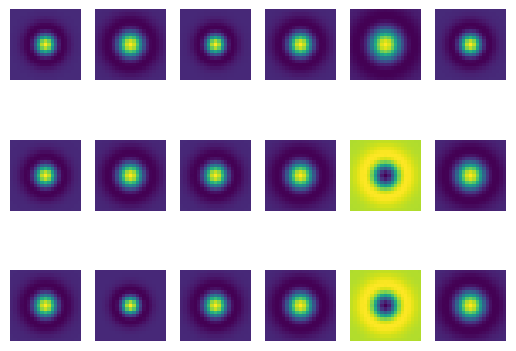

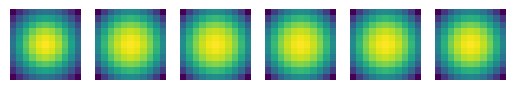

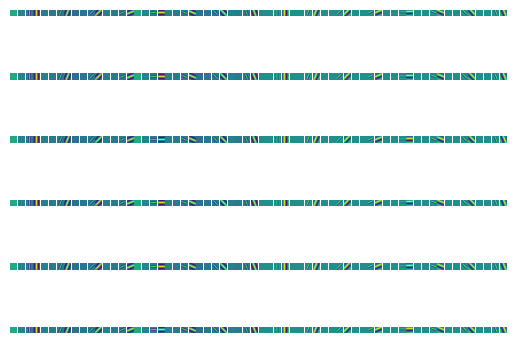

In [23]:
__ = jax.tree_util.tree_map(lambda x: plot_filters(x), _)

In [24]:
def check_trainable(path):
    # return ("A" in path) or ("alpha_chrom_rg" in path) or ("alpha_chrom_yb" in path)
    return False

In [5]:
trainable_tree = freeze(flax.traverse_util.path_aware_map(lambda path, v: "non_trainable" if check_trainable(path)  else "trainable", state.params))
trainable_tree

FrozenDict({
    GDN_0: {
        Conv_0: {
            kernel: 'trainable',
            bias: 'trainable',
        },
    },
    Conv_0: {
        kernel: 'trainable',
    },
    GDN_1: {
        Conv_0: {
            kernel: 'trainable',
            bias: 'trainable',
        },
    },
    CenterSurroundLogSigmaK_0: {
        logsigma: 'trainable',
        K: 'trainable',
        A: 'trainable',
    },
    GDNGaussian_0: {
        GaussianLayerGamma_0: {
            gamma: 'trainable',
            A: 'trainable',
        },
    },
    GaborLayerLogSigmaCoupled__0: {
        freq: 'trainable',
        logsigma2: 'trainable',
        theta: 'trainable',
    },
})

In [26]:
optimizers = {
    "trainable": optax.adam(learning_rate=config.LEARNING_RATE),
    "non_trainable": optax.set_to_zero(),
}

In [27]:
tx = optax.multi_transform(optimizers, trainable_tree)

In [28]:
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), tx, input_shape=(1,384,512,3))
state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))

In [6]:
param_count = sum(x.size for x in jax.tree_util.tree_leaves(state.params))
param_count

103

In [30]:
wandb.run.summary["trainable_parameters"] = param_count

<class 'AttributeError'>: 'NoneType' object has no attribute 'summary'

In [31]:
state = state.replace(params=unfreeze(state.params))

# ## DN 0
# state.params["GDNStarSign_0"]["Conv_0"]["bias"] = jnp.ones_like(state.params["GDNStarSign_0"]["Conv_0"]["bias"])*0.1
# state.params["GDNStarSign_0"]["Conv_0"]["kernel"] = jnp.ones_like(state.params["GDNStarSign_0"]["Conv_0"]["kernel"])*0.5

# ## DN J&H
# state.params["GDNStarSign_1"]["Conv_0"]["bias"] = jnp.ones_like(state.params["GDNStarSign_1"]["Conv_0"]["bias"])*30.**2
# state.params["GDNStarSign_1"]["Conv_0"]["kernel"] = jnp.ones_like(state.params["GDNStarSign_1"]["Conv_0"]["kernel"])*0.5

# state.params["GDNStarDisplacement_0"]["Conv_0"]["bias"] = jnp.ones_like(state.params["GDNStarDisplacement_0"]["Conv_0"]["bias"])*10.**2
# state.params["GDNStarDisplacement_0"]["Conv_0"]["kernel"] = jnp.ones_like(state.params["GDNStarDisplacement_0"]["Conv_0"]["kernel"])*0.5

# state.params["GDNStarDisplacement_1"]["Conv_0"]["bias"] = jnp.ones_like(state.params["GDNStarDisplacement_1"]["Conv_0"]["bias"])*10.**2
# state.params["GDNStarDisplacement_1"]["Conv_0"]["kernel"] = jnp.ones_like(state.params["GDNStarDisplacement_1"]["Conv_0"]["kernel"])*0.5

# state.params["GDNGaussianStarRunning_0"]["GaussianLayerGamma_0"]["gamma"] = jnp.ones_like(state.params["GDNGaussianStarRunning_0"]["GaussianLayerGamma_0"]["gamma"])*(1./0.04)
# state.params["GDNGaussianStarRunning_1"]["GaussianLayerGamma_0"]["gamma"] = jnp.ones_like(state.params["GDNGaussianStarRunning_1"]["GaussianLayerGamma_0"]["gamma"])*(1./0.04)
# state.params["GDNGaussianStarRunning_2"]["GaussianLayerGamma_0"]["gamma"] = jnp.ones_like(state.params["GDNGaussianStarRunning_2"]["GaussianLayerGamma_0"]["gamma"])*(1./0.04)

# state.params["GDNSpatioFreqOrient_0"]["GaussianLayerGamma_0"]["gamma"] = jnp.ones_like(state.params["GDNSpatioFreqOrient_0"]["GaussianLayerGamma_0"]["gamma"])*(1./0.1)
# state.params["GDNSpatioFreqOrient_1"]["GaussianLayerGamma_0"]["gamma"] = jnp.ones_like(state.params["GDNSpatioFreqOrient_1"]["GaussianLayerGamma_0"]["gamma"])*(1./0.1)
# state.params["GDNSpatioFreqOrient_2"]["GaussianLayerGamma_0"]["gamma"] = jnp.ones_like(state.params["GDNSpatioFreqOrient_2"]["GaussianLayerGamma_0"]["gamma"])*(1./0.1)

# state.params["GDNSpatioFreqOrient_0"]["OrientGaussian_0"]["sigma"] = jnp.ones_like(state.params["GDNSpatioFreqOrient_0"]["OrientGaussian_0"]["sigma"])*20
# state.params["GDNSpatioFreqOrient_1"]["OrientGaussian_0"]["sigma"] = jnp.ones_like(state.params["GDNSpatioFreqOrient_1"]["OrientGaussian_0"]["sigma"])*20
# state.params["GDNSpatioFreqOrient_2"]["OrientGaussian_0"]["sigma"] = jnp.ones_like(state.params["GDNSpatioFreqOrient_2"]["OrientGaussian_0"]["sigma"])*20

# state.params["GDNSpatioFreqOrient_0"]["bias"] = jnp.tile(jnp.array([0.001, 0.002, 0.0035, 0.01])/100, reps=config.N_ORIENTATIONS*2)
# state.params["GDNSpatioFreqOrient_1"]["bias"] = jnp.tile(jnp.array([0.001, 0.002, 0.0035, 0.01])/100, reps=config.N_ORIENTATIONS*2)
# state.params["GDNSpatioFreqOrient_2"]["bias"] = jnp.tile(jnp.array([0.001, 0.002, 0.0035, 0.01])/100, reps=config.N_ORIENTATIONS*2)

## Center Surround
state.params["CenterSurroundLogSigmaK_0"]["K"] = jnp.array([1.1,0.9,1.01,1.01,1.01,1.01,
                                                            1.01,1.01,1.1,0.9,1.01,1.01,
                                                            1.01,1.01,1.01,1.01,1.1,0.9])
state.params["CenterSurroundLogSigmaK_0"]["A"] = jnp.array([1,1,0,0,0,0,
                                                            0,0,1,1.9,0,0,
                                                            0,0,0,0,1,1])

## GDNGaussian
state.params["GDNGaussian_0"]["GaussianLayerGamma_0"]["gamma"] = jnp.ones_like(state.params["GDNGaussian_0"]["GaussianLayerGamma_0"]["gamma"])*(1./0.04)

## Gabor
# state.params["GaborLayerLogSigmaCoupled__0"]["A"] = jnp.array([1,1,0,0,0,0,
#                                                                0,0,1,1.9,0,0,
#                                                                0,0,0,0,1,1])

state = state.replace(params=freeze(state.params))

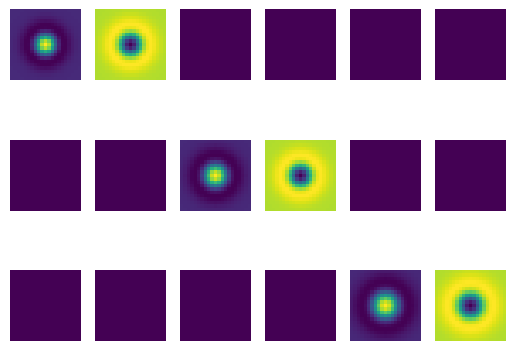

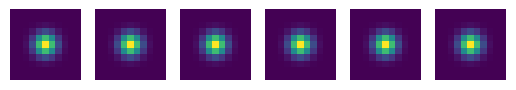

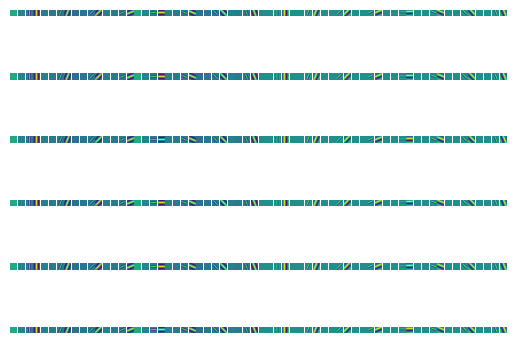

In [32]:
pred, _ = state.apply_fn({"params": state.params, **state.state}, jnp.ones(shape=(1,384,512,3)), train=True, mutable=list(state.state.keys()))
__ = jax.tree_util.tree_map(lambda x: plot_filters(x), _)

Before actually training the model we're going to set up the checkpointer to be able to save our trained models:

In [33]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(state)

In [34]:
metrics_history = {
    "train_loss": [],
    "val_loss": [],
}

In [35]:
batch = next(iter(dst_train_rdy.as_numpy_iterator()))

In [36]:
from functools import partial

In [37]:
@jax.jit
def forward(state, inputs):
    return state.apply_fn({"params": state.params, **state.state}, inputs, train=False)

In [7]:
%%time
outputs = forward(state, batch[0])
outputs.shape

CPU times: user 8.96 s, sys: 2.46 s, total: 11.4 s
Wall time: 11.4 s


(64, 96, 128, 64)

In [39]:
%%time
s1 = train_step(state, batch)

CPU times: user 23.7 s, sys: 402 ms, total: 24.2 s
Wall time: 25.6 s


In [40]:
# jax.config.update("jax_debug_nans", True)

In [41]:
%%time
for epoch in range(config.EPOCHS):
    ## Training
    for batch in dst_train_rdy.as_numpy_iterator():
        state = train_step(state, batch)
        state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))
        # state = compute_metrics(state=state, batch=batch)
        # break

    ## Log the metrics
    for name, value in state.metrics.compute().items():
        metrics_history[f"train_{name}"].append(value)
    
    ## Empty the metrics
    state = state.replace(metrics=state.metrics.empty())

    ## Evaluation
    for batch in dst_val_rdy.as_numpy_iterator():
        state = compute_metrics(state=state, batch=batch)
        # break
    for name, value in state.metrics.compute().items():
        metrics_history[f"val_{name}"].append(value)
    state = state.replace(metrics=state.metrics.empty())
    
    ## Checkpointing
    if metrics_history["val_loss"][-1] <= min(metrics_history["val_loss"]):
        orbax_checkpointer.save(os.path.join(wandb.run.dir, "model-best"), state, save_args=save_args, force=True) # force=True means allow overwritting.

    wandb.log({f"{k}": wandb.Histogram(v) for k, v in flatten_params(state.params).items()}, commit=False)
    wandb.log({"epoch": epoch+1, **{name:values[-1] for name, values in metrics_history.items()}})
    print(f'Epoch {epoch} -> [Train] Loss: {metrics_history["train_loss"][-1]} [Val] Loss: {metrics_history["val_loss"][-1]}')
    # break

Epoch 0 -> [Train] Loss: -0.5967585444450378 [Val] Loss: -0.7400473952293396
Epoch 1 -> [Train] Loss: -0.6142905950546265 [Val] Loss: -0.754859209060669
Epoch 2 -> [Train] Loss: -0.6332786679267883 [Val] Loss: -0.7675650119781494
Epoch 3 -> [Train] Loss: -0.6521397829055786 [Val] Loss: -0.7770469784736633
Epoch 4 -> [Train] Loss: -0.6585325002670288 [Val] Loss: -0.7844635248184204
Epoch 5 -> [Train] Loss: -0.6659783720970154 [Val] Loss: -0.7893134355545044
Epoch 6 -> [Train] Loss: -0.6810426712036133 [Val] Loss: -0.7937338948249817
Epoch 7 -> [Train] Loss: -0.6838777661323547 [Val] Loss: -0.79702228307724
Epoch 8 -> [Train] Loss: -0.6840782761573792 [Val] Loss: -0.8004208207130432
Epoch 9 -> [Train] Loss: -0.6862733364105225 [Val] Loss: -0.8048034906387329
Epoch 10 -> [Train] Loss: -0.707051694393158 [Val] Loss: -0.8070200681686401
Epoch 11 -> [Train] Loss: -0.7033995389938354 [Val] Loss: -0.8092404007911682
Epoch 12 -> [Train] Loss: -0.7106233239173889 [Val] Loss: -0.8102641701698303


Save the final model as well in case we want to keep training from it or whatever:

In [42]:
orbax_checkpointer.save(os.path.join(wandb.run.dir, "model-final"), state, save_args=save_args)

<class 'KeyboardInterrupt'>: 

Exception ignored in: <function _xla_gc_callback at 0x7fabcd793430>
Traceback (most recent call last):
  File "/home/jorge/miniconda3/envs/dl/lib/python3.8/site-packages/jax/_src/lib/__init__.py", line 103, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


In [43]:
wandb.finish()

In [44]:
import matplotlib.pyplot as plt

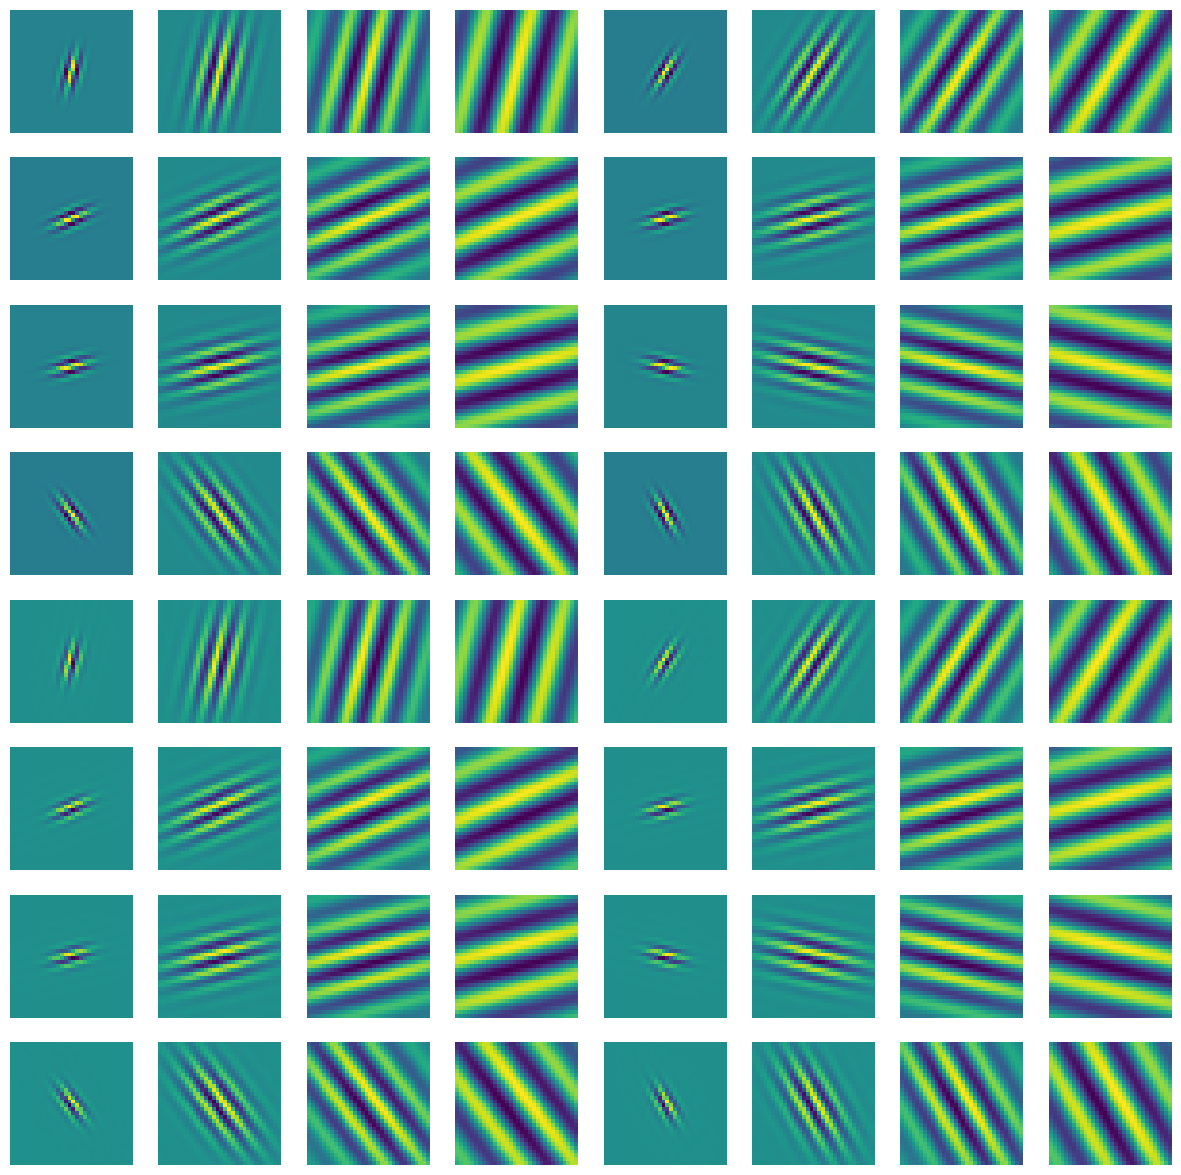

In [45]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(state.state["precalc_filter"]["GaborLayerLogSigmaCoupled__0"]["kernel"][:,:,0,i])
    ax.axis("off")
plt.show()

In [46]:
kernel = state.state["precalc_filter"]["GaborLayerLogSigmaCoupled__2"]["kernel"]
kernel.shape

<class 'KeyError'>: 'GaborLayerLogSigmaCoupled__2'

In [ ]:
kernel_f_fft = jnp.fft.fftn(kernel[:,:,0,:], axes=(0,1))
kernel_f_fft = jnp.fft.fftshift(kernel_f_fft)
kernel_f_fft_abs_sum = jnp.abs(kernel_f_fft).sum(axis=-1)
kernel_f_fft.shape, kernel_f_fft_abs_sum.shape

<class 'NameError'>: name 'kernel' is not defined

<class 'NameError'>: name 'kernel_f_fft' is not defined

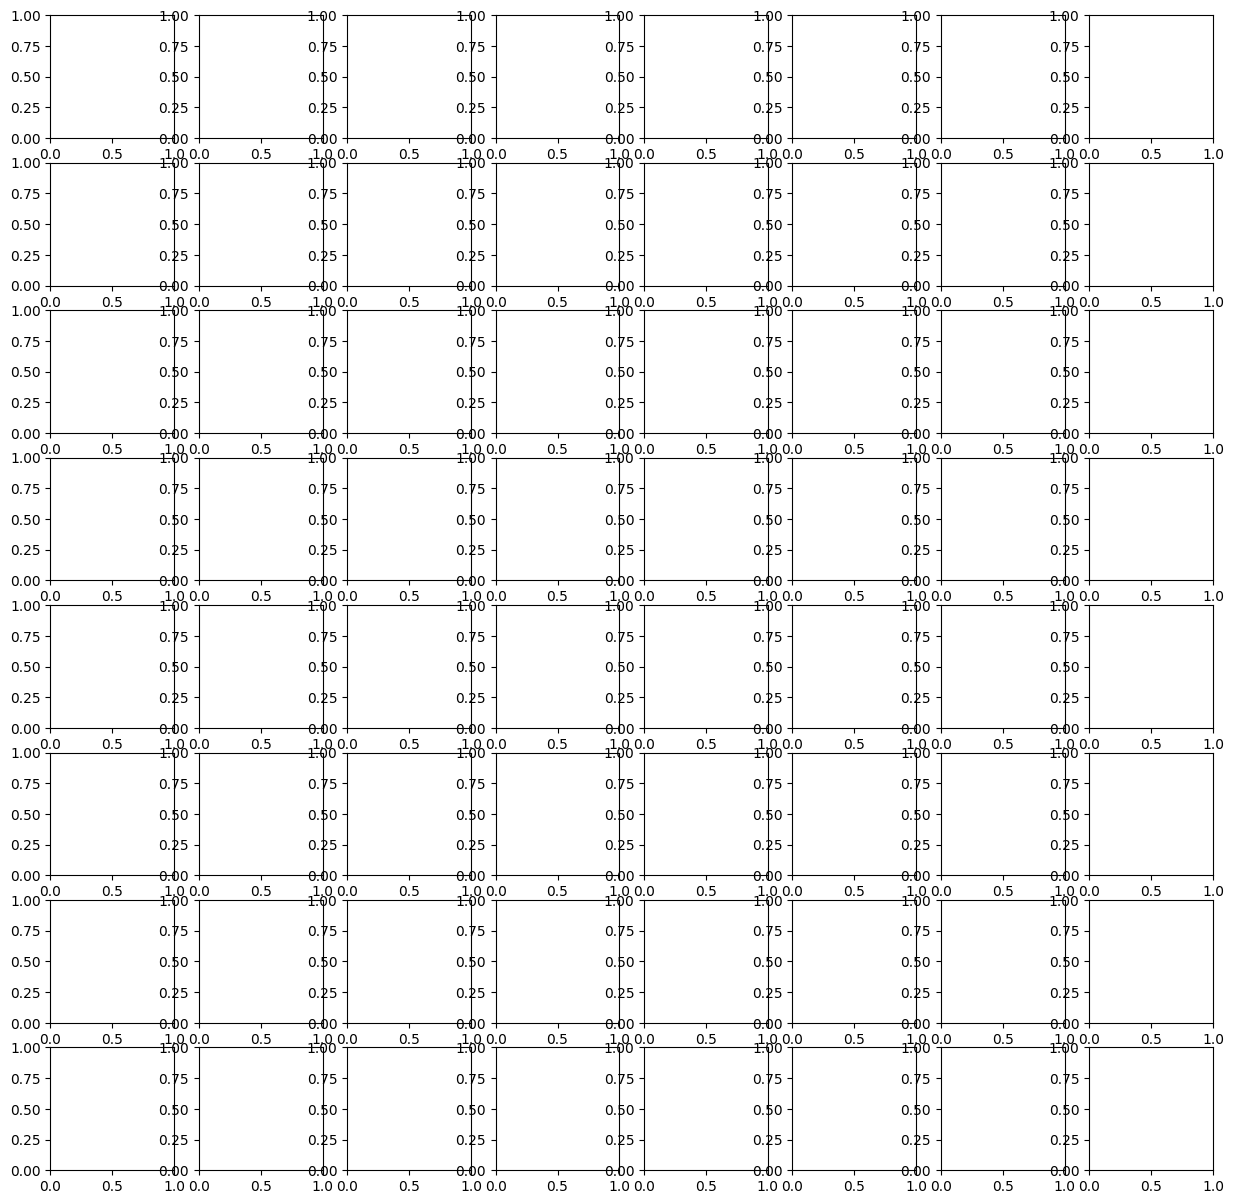

In [ ]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(jnp.abs(kernel_f_fft[:,:,i]))
    ax.axis("off")
plt.show()

In [ ]:
plt.imshow(kernel_f_fft_abs_sum)
plt.show()

<class 'NameError'>: name 'kernel_f_fft_abs_sum' is not defined

In [ ]:
state.params["CSFFourier_0"]

<class 'KeyError'>: 'CSFFourier_0'

In [ ]:
csf_sso, fx, fy = CSFFourier.csf_sso(fs=64, Nx=512//2, Ny=384//2, alpha=state.params["CSFFourier_0"]["alpha_achrom"],
                   beta=state.params["CSFFourier_0"]["beta_achrom"], g=330.74, fm=state.params["CSFFourier_0"]["fm"], 
                    l=0.837, s=state.params["CSFFourier_0"]["s"], w=1.0, os=6.664)

<class 'KeyError'>: 'CSFFourier_0'

In [ ]:
csf_chrom_rg, csf_chrom_yb, fx, fy = CSFFourier.csf_chrom(fs=64, Nx=512//2, Ny=384//2, alpha_rg=state.params["CSFFourier_0"]["alpha_chrom_rg"],
                   alpha_yb=state.params["CSFFourier_0"]["alpha_chrom_yb"],
                   beta=state.params["CSFFourier_0"]["beta_chrom"])

<class 'KeyError'>: 'CSFFourier_0'

In [ ]:
def scale_csf(csf_a, csf_rg, csf_yb):
    csfs = jnp.stack([csf_a, csf_rg, csf_yb], axis=-1)
    E1 = jnp.sum(jnp.ones_like(csfs)**2)#**(1/2)
    E_CSF = jnp.sum(csfs**2)#**(1/2)
    csfs = (csfs/E_CSF)*E1
    return csfs[:,:,0], csfs[:,:,1], csfs[:,:,2], csfs.min(), csfs.max()

In [ ]:
csf_sso, csf_chrom_rg, csf_chrom_yb, m, M = scale_csf(csf_sso, csf_chrom_rg, csf_chrom_yb)
# csfs = scale_csf(csf_sso, csf_chrom_rg, csf_chrom_yb)

<class 'NameError'>: name 'csf_sso' is not defined

In [ ]:
plt.matshow(csf_sso, vmin=m, vmax=M)
plt.colorbar()
plt.show()

<class 'NameError'>: name 'csf_sso' is not defined

In [ ]:
plt.matshow(csf_chrom_rg, vmin=m, vmax=M)
plt.colorbar()
plt.show()

<class 'NameError'>: name 'csf_chrom_rg' is not defined

In [ ]:
plt.matshow(csf_chrom_yb, vmin=m, vmax=M)
plt.colorbar()
plt.show()

<class 'NameError'>: name 'csf_chrom_yb' is not defined

In [ ]:
plt.plot(state.params["GDNSpatioFreqOrient_0"]["bias"])
plt.plot(state.params["GDNSpatioFreqOrient_1"]["bias"])
plt.plot(state.params["GDNSpatioFreqOrient_2"]["bias"])
plt.show()

<class 'KeyError'>: 'GDNSpatioFreqOrient_0'

## Correlation per layer

In [ ]:
@jax.jit
def forward_intermediates(state, inputs):
    return state.apply_fn({"params": state.params, **state.state}, inputs, train=False, capture_intermediates=True)

In [ ]:
pred_ref, extra_ref = forward_intermediates(state, batch[0][:1])
pred_dist, extra_dist = forward_intermediates(state, batch[1][:1])

In [ ]:
empty_tree = jax.tree_util.tree_map(lambda x: [], extra_ref["intermediates"])

In [ ]:
def mse_trees(tree1, tree2):
    return jax.tree_util.tree_map(lambda x,y: jnp.sum((x-y)**2)**(1/2), tree1, tree2)

In [ ]:
diffs = mse_trees(extra_ref["intermediates"], extra_dist["intermediates"])

In [ ]:
def join_tree_values(*trees):
    return jax.tree_util.tree_map(lambda *args: [*args], *trees)

In [ ]:
dst_train_rdy_eval = dst_train.dataset.batch(1, drop_remainder=True)

In [ ]:
from tqdm.auto import tqdm

In [ ]:
trees, moses = [], []
for batch in tqdm(dst_train_rdy_eval.as_numpy_iterator()):
    pred_ref, extra_ref = forward_intermediates(state, batch[0])
    pred_dist, extra_dist = forward_intermediates(state, batch[1])
    diff = mse_trees(extra_ref["intermediates"], extra_dist["intermediates"])
    trees.append(diff)
    moses.extend(batch[2])


0it [00:00, ?it/s]
6it [00:00, 52.58it/s]
14it [00:00, 63.75it/s]
22it [00:00, 67.72it/s]
31it [00:00, 73.26it/s]
40it [00:00, 76.34it/s]
49it [00:00, 78.23it/s]
58it [00:00, 79.95it/s]
67it [00:00, 78.76it/s]
76it [00:01, 79.34it/s]
85it [00:01, 80.85it/s]
94it [00:01, 80.33it/s]
103it [00:01, 80.76it/s]
112it [00:01, 81.10it/s]
121it [00:01, 81.43it/s]
130it [00:01, 81.79it/s]
139it [00:01, 81.71it/s]
148it [00:01, 81.90it/s]
157it [00:01, 82.38it/s]
166it [00:02, 82.51it/s]
175it [00:02, 80.03it/s]
184it [00:02, 81.40it/s]
193it [00:02, 79.55it/s]
201it [00:02, 79.05it/s]
210it [00:02, 78.78it/s]
218it [00:02, 78.79it/s]
226it [00:02, 79.09it/s]
235it [00:02, 78.41it/s]
244it [00:03, 79.81it/s]
253it [00:03, 80.34it/s]
262it [00:03, 80.85it/s]
271it [00:03, 80.65it/s]
280it [00:03, 80.95it/s]
289it [00:03, 81.32it/s]
298it [00:03, 81.21it/s]
307it [00:03, 81.52it/s]
316it [00:03, 81.48it/s]
325it [00:04, 81.75it/s]
334it [00:04, 82.22it/s]
343it [00:04, 82.07it/s]
352it [00:04, 79.

In [ ]:
diffs = join_tree_values(*trees)

In [ ]:
import scipy.stats as stats

In [ ]:
diffs_2 = jax.tree_util.tree_map(lambda x: x[0], diffs)

<class 'IndexError'>: Too many indices for array: 1 non-None/Ellipsis indices for dim 0.

In [ ]:
def correlation(a, b):
    try:
        return stats.pearsonr(a, b)[0]
    except:
        return None

In [ ]:
correlation(diffs["GDNStarSign_0"]["__call__"][0], moses)

<class 'KeyError'>: 'GDNStarSign_0'

In [ ]:
correlation(diffs["JamesonHurvich_0"]["__call__"][0], moses)

<class 'KeyError'>: 'JamesonHurvich_0'

In [ ]:
correlation(diffs["GDNStarSign_1"]["__call__"][0], moses), correlation(diffs["GDNStarDisplacement_1"]["__call__"][0], moses), correlation(diffs["GDNStarDisplacement_1"]["__call__"][0], moses)

<class 'KeyError'>: 'GDNStarSign_1'

In [ ]:
correlation(diffs["CSFFourier_0"]["__call__"][0], moses)

<class 'KeyError'>: 'CSFFourier_0'

In [ ]:
correlation(diffs["GDNGaussianStarRunning_0"]["__call__"][0], moses), correlation(diffs["GDNGaussianStarRunning_1"]["__call__"][0], moses), correlation(diffs["GDNGaussianStarRunning_2"]["__call__"][0], moses)

<class 'KeyError'>: 'GDNGaussianStarRunning_0'

In [ ]:
correlation(diffs["GaborLayerLogSigmaCoupled__0"]["__call__"][0][0], moses), correlation(diffs["GaborLayerLogSigmaCoupled__1"]["__call__"][0][0], moses), correlation(diffs["GaborLayerLogSigmaCoupled__2"]["__call__"][0][0], moses)

<class 'KeyError'>: 'GaborLayerLogSigmaCoupled__1'

In [ ]:
correlation(diffs["GDNSpatioFreqOrient_0"]["__call__"][0], moses), correlation(diffs["GDNSpatioFreqOrient_1"]["__call__"][0], moses), correlation(diffs["GDNSpatioFreqOrient_2"]["__call__"][0], moses)

<class 'KeyError'>: 'GDNSpatioFreqOrient_0'

In [8]:
correlation(diffs["__call__"][0], moses)

-0.8814759979367915